In [96]:
import qutip as qt
import krotov as kt
import numpy as np
import matplotlib.pyplot as plt

Scaling time and frequency differently: one time unit below is one microsecond, so one frequency unit below should be scaled by 1e6 to get rad/s.

In [97]:
N = 2
T = 25e-6
cs_strength = 1e2
omega_nut = 5e4
lambda_a = 1e6

In [98]:
I_x = sum([
    qt.tensor(  # I_x^i
        [qt.identity(2)]*i
        + [qt.sigmax()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_y = sum([
    qt.tensor(  # I_x^i
        [qt.identity(2)]*i
        + [qt.sigmay()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_z = sum([
    qt.tensor(  # I_x^i
        [qt.identity(2)]*i
        + [qt.sigmaz()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

In [99]:
def hamiltonian(N=4, cs_strength=1, a0=1, a1=1):
    """System of N spin-1/2 particles
    
    Arguments:
        N (int): Number of particles
        cs_strength (float): Strength of chemical shift interaction, in rad/s
        a0 (float): Initial amplitude of first control Hamiltonian
        a1 (float): Initial amplitude of second control Hamiltonian
    """
    chemical_shift = np.random.normal(scale=cs_strength, size=(N,))
    H_cs = sum([
        qt.tensor([qt.identity(2)]*i
               + [chemical_shift[i] * qt.sigmaz()]
               + [qt.identity(2)]*(N-i-1))
        for i in range(N)
    ])
    H_cx = omega_nut * I_x
    H_cy = omega_nut * I_y
    
    def cx(t, args):
        return a0 * kt.shapes.flattop(
            t, t_start=0, t_stop=T, t_rise=T/10, func='blackman'
        )
    def cy(t, args):
        return a1 * kt.shapes.flattop(
            t, t_start=0, t_stop=T, t_rise=T/10, func='blackman'
        )
    
    return [H_cs, [H_cx, cx], [H_cy, cy]]

In [100]:
H_c_labels = [
    r'$H_x$',
    r'$H_y$',
]

In [101]:
H = hamiltonian(N=N, cs_strength=cs_strength, a0=0.7, a1=0)

In [102]:
tlist = np.linspace(0, T, 100)

In [103]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

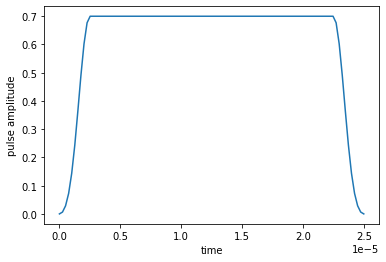

In [104]:
plot_pulse(H[1][1], tlist)

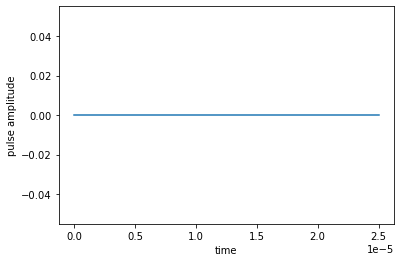

In [105]:
plot_pulse(H[2][1], tlist)

In [106]:
#  2**N basis states
basis_states = [
    qt.tensor(
        [qt.basis(2, np.mod(int(np.floor(i / 2**j)), 2)) for j in range(N)]
    ) for i in range(2**N)
]

In [107]:
U_targ = qt.propagator(I_x, np.pi/4)

In [108]:
objectives = kt.gate_objectives(
    basis_states=basis_states,
    gate=U_targ,
    H=H
)

In [109]:
def S(t):
    """Shape function for the field update"""
    return kt.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T/10, t_fall=T/10, func='blackman'
    )

In [110]:
pulse_options = {
    H[1][1]: dict(lambda_a=lambda_a, update_shape=S),
    H[2][1]: dict(lambda_a=lambda_a, update_shape=S),
}

In [111]:
e_ops = [
    I_x, I_y, I_z
]

e_labels = [
    r'$I_x$',
    r'$I_y$',
    r'$I_z$',
]

In [112]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=e_ops)

In [113]:
def plot_population(result, e_labels):
    fig, ax = plt.subplots()
    for i, label in enumerate(e_labels):
        ax.plot(result.times, result.expect[i], label=label)
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('expectation value')
    plt.show(fig)

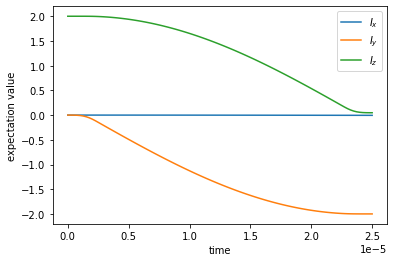

In [114]:
plot_population(guess_dynamics, e_labels)

In [115]:
opt_result = kt.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=kt.propagators.expm,
    chi_constructor=kt.functionals.chis_ss,
    info_hook=kt.info_hooks.print_table(J_T=kt.functionals.J_T_ss),
    check_convergence=kt.convergence.Or(
        kt.convergence.value_below('1e-4', name='J_T'),
        kt.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     2.93e-04    0.00e+00   2.93e-04        n/a        n/a     1
1     2.36e-04    2.77e-11   2.36e-04  -5.68e-05  -5.68e-05     2
2     1.90e-04    2.22e-11   1.90e-04  -4.56e-05  -4.56e-05     2
3     1.54e-04    1.78e-11   1.54e-04  -3.66e-05  -3.66e-05     2
4     1.24e-04    1.43e-11   1.24e-04  -2.93e-05  -2.93e-05     2
5     1.01e-04    1.15e-11   1.01e-04  -2.35e-05  -2.35e-05     2
6     8.19e-05    9.20e-12   8.19e-05  -1.89e-05  -1.89e-05     2


In [116]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=e_ops)

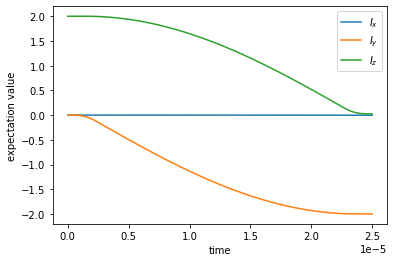

In [117]:
plot_population(opt_dynamics, e_labels)

In [118]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [119]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr0, ax_ctr1, ax_dyn] = plt.subplots(
        nrows=3, ncols=1,
        figsize=(8, 12),
        sharex=True
    )
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            kt.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=e_ops
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = [f'{label} (guess)' for label in e_labels] # '0 (guess)', '1 (guess)'
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = [f'{label} (optimized)' for label in e_labels]
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None] * len(e_labels)
        ax_ctr0.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_ctr1.plot(
            dynamics.times,
            controls[1],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        for i in range(len(e_labels)):
            ax_dyn.plot(
                dynamics.times,
                dynamics.expect[i],
                # TODO figure out below
                label=pop_labels[i],
                color=colors[i],
                ls=ls,
                alpha=alpha,
            )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('expectation')
    ax_ctr0.set_title(H_c_labels[0])
    ax_ctr0.legend()
    ax_ctr0.set_xlabel('time')
    ax_ctr0.set_ylabel('control amplitude')
    ax_ctr1.set_title(H_c_labels[1])
    ax_ctr1.legend()
    ax_ctr1.set_xlabel('time')
    ax_ctr1.set_ylabel('control amplitude')
    plt.show(fig)

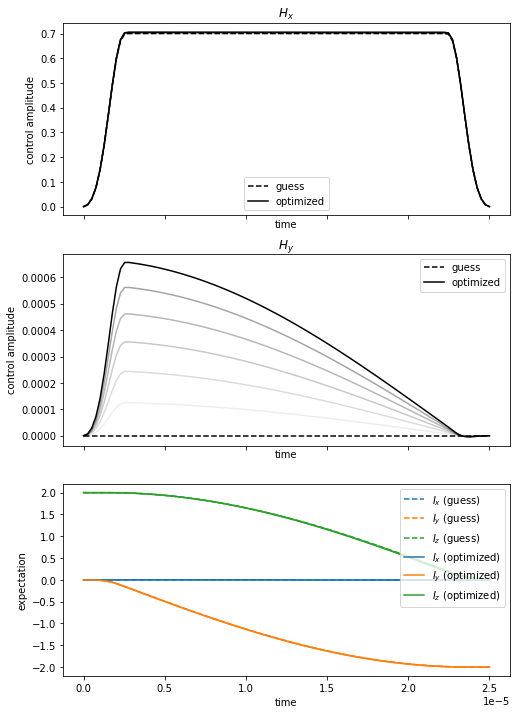

In [120]:
plot_iterations(opt_result)

## Ensemble robustness

In [121]:
from krotov.parallelization import parallel_map

In [159]:
def scale_control(H, *, mu):
    """Scale all control Hamiltonians by `mu`."""
    H_scaled = []
    for spec in H:
        if isinstance(spec, list):
            H_scaled.append([mu * spec[0], spec[1]])
        else:
            H_scaled.append(spec)
    return H_scaled

In [160]:
mu_vals = np.linspace(0.9, 1.1, 50)

In [161]:
def pop_error(obj, mu):
    """Population error defined as magnetization away  from I_y
    """
    res = obj.mesolve(tlist, H=scale_control(obj.H, mu=mu), e_ops=[I_y])
    return N + res.expect[0][-1]

In [162]:
def _f(mu):
    return pop_error(opt_result.optimized_objectives[0], mu=mu)

pop_errors_norobust = parallel_map(_f, mu_vals)

In [163]:
def plot_robustness(mu_vals, pop_errors, pop_errors0=None):
    fig, ax = plt.subplots()
    ax.plot(mu_vals, pop_errors, label='1')
    if pop_errors0 is not None:
        ax.set_prop_cycle(None)  # reset colors
        if isinstance(pop_errors0, list):
            for (i, pop_errors_prev) in enumerate(pop_errors0):
                ax.plot(
                    mu_vals, pop_errors_prev, ls='dotted', label=("%d" % (-i))
                )
        else:
            ax.plot(mu_vals, pop_errors0, ls='dotted', label='0')
    ax.set_xlabel("Relative coupling strength")
    ax.set_ylabel('Error')
    ax.set_yscale('log')
    if pop_errors0 is not None:
        ax.legend()
    plt.show(fig)

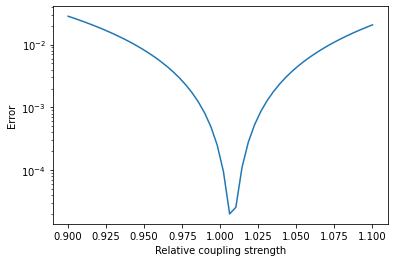

In [164]:
plot_robustness(mu_vals, pop_errors_norobust)

In [128]:
ensemble_mu = np.linspace(0.9, 1.1, 3)

In [129]:
H_ensemble = [scale_control(H, mu=mu) for mu in ensemble_mu]

In [149]:
objective_state_to_state = [kt.objectives.Objective(
    initial_state=qt.tensor([qt.basis(2, 0)] * N),
    target=qt.tensor([(qt.basis(2, 0) - 1j*qt.basis(2, 1)).unit()]*N), H=H
)]

In [150]:
ensemble_objectives = kt.objectives.ensemble_objectives(
    objective_state_to_state, H_ensemble, keep_original_objectives=False,
)

In [146]:
def print_J_T_per_target(**kwargs):
    iteration = kwargs['iteration']
    N = len(ensemble_mu)
    num_objectives = len(objectives)
    if iteration == 0:
        print(
            "iteration "
            + "%11s " % "J_T(avg)"
            + " ".join([("J_T(μ=%.2f)" % μ) for μ in ensemble_mu])
        )
    J_T_vals = 1 - kwargs['tau_vals'].real
    J_T = np.mean(J_T_vals)
    J_T_ensemble = [np.mean(J_T_vals[i*num_objectives:(i+1)*num_objectives]) for i in range(N)]
    print(
        ("%9d " % iteration)
        + ("%11.2e " % J_T)
        + " ".join([("%11.2e" % v) for v in J_T_ensemble])
    )

In [154]:
lambda_a = 1e5

pulse_options = {
    H[1][1]: dict(lambda_a=lambda_a, update_shape=S),
    H[2][1]: dict(lambda_a=lambda_a, update_shape=S),
}

In [155]:
opt_result_robust = kt.optimize_pulses(
    ensemble_objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=kt.propagators.expm,
    chi_constructor=kt.functionals.chis_ss,
    info_hook=kt.info_hooks.print_table(J_T=kt.functionals.J_T_ss),
#     info_hook=kt.info_hooks.chain(
#         print_J_T_per_target,
#         kt.info_hooks.print_table(
#             J_T=kt.functionals.J_T_ss
#         ),
#     ),
    check_convergence=kt.convergence.Or(
        kt.convergence.value_below('1e-4', name='J_T'),
        kt.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
    iter_stop=5
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.22e-03    0.00e+00   8.22e-03        n/a        n/a     0
1     8.14e-03    3.86e-10   8.14e-03  -7.99e-05  -7.99e-05     1
2     8.13e-03    4.60e-11   8.13e-03  -9.56e-06  -9.56e-06     1
3     8.13e-03    6.19e-12   8.13e-03  -1.29e-06  -1.29e-06     1
4     8.13e-03    1.10e-12   8.13e-03  -2.33e-07  -2.33e-07     1
5     8.13e-03    2.86e-13   8.13e-03  -6.15e-08  -6.15e-08     1


In [157]:
opt_result_robust

Krotov Optimization Result
--------------------------
- Started at 2020-10-08 18:17:27
- Number of objectives: 3
- Number of iterations: 5
- Reason for termination: Reached 5 iterations
- Ended at 2020-10-08 18:17:37 (0:00:10)

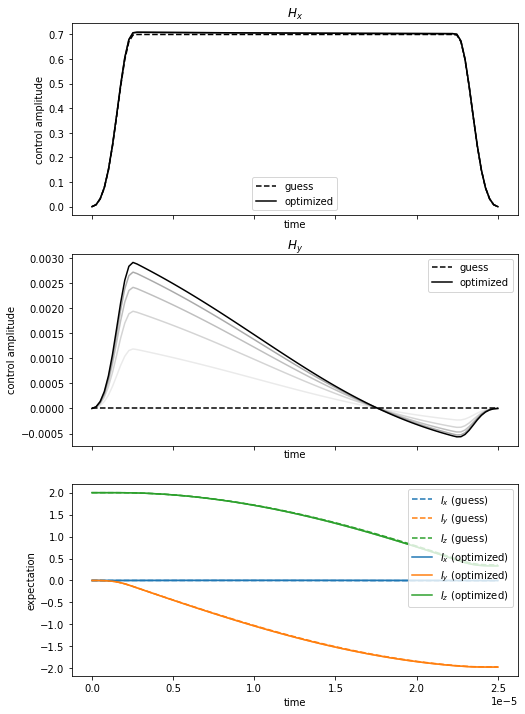

In [158]:
plot_iterations(opt_result_robust)

In [165]:
def _f(mu):
    return pop_error(opt_result_robust.optimized_objectives[0], mu=mu)

pop_errors_robust = parallel_map(_f, mu_vals)

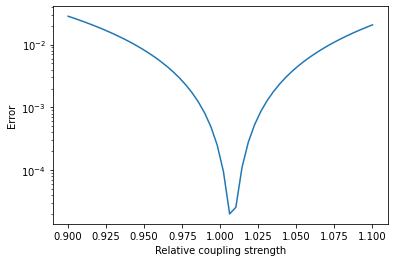

In [171]:
plot_robustness(mu_vals, pop_errors_norobust)